In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.special import sph_harm
from OutputInterface import OutputInterface
import sperhical_expansion as se

In [29]:
file_name = 'output_files/Hydrogen.out'
output = OutputInterface(file_name)
Ip = -output.saved_orbitals[output.HOMO][0]
kappa = np.sqrt(2*Ip)

In [5]:
omega = 0.057     # Frequency of light
Up = 0.22         # Ponderomotive potential

dp = 4./250
pz_list = np.arange(-1.7, 1.7, dp)
px_list = np.arange(0, 1.7, dp)
#pz_grid, px_grid = np.meshgrid(pz_list, px_list)
py = 0

### Functions to calculate the transition amplitude:

In [6]:
def Af(t):
    return 2*np.sqrt(Up) * np.cos(omega * t)


def Ef(t):
    return 2*np.sqrt(Up) * omega * np.sin(omega * t)


def saddle_times(p_par, p_perp, n):
    """
    Finds the saddle point times for a monochromatic wave A = 2*sqrt(Up) cos(omega * t). See Eq. (4.4) in Andrew's thesis.

    :param p_par: parallel momentum (pz)
    :param p_perp: perpendicular momentum
    """
    t1 =  2*np.pi*n/omega + 1/omega * np.arccos((-p_par - 1j*np.sqrt(2*Ip + p_perp**2)) / (2*np.sqrt(Up)))
    t2 =  2*np.pi*n/omega - 1/omega * np.arccos((-p_par + 1j*np.sqrt(2*Ip + p_perp**2)) / (2*np.sqrt(Up)))
    return t1, t2


def action(p, pz, t):
    """
    Action given the vector potential above. Assuming that the lower limit is just 0...
    """
    return Ip*t + 0.5*p**2 + Up*(t + 1/(2*omega) * np.sin(2*omega*t)) + 2*pz/omega * np.sqrt(Up)*np.sin(omega*t)


def I1(kappa, ddS, S, Z=1):
    """
    Factor dependent of ts needed in calculation of M_asymp_LG

    :param kappa: sqrt(2*Ip)
    :param ddS: second derivative of the action
    :param S: the action
    :param Z: charge of the leftover core (+1 for single electron ionization)
    """
    nu = Z/kappa - 2
    return ddS**(-nu) * 1j**(nu/2) * gamma(nu/2) / (2*gamma(nu)) * np.sqrt(2*np.pi*1j/ddS) * (2*ddS)**(nu/2) * np.exp(1j * S)


def I2(kappa, l, Z=1):
    """
    Factor independent of ts, needed in the calculation of M_asymp_LG
    """
    nu = Z/kappa
    factor = kappa**(nu+3/2) * gamma(l+nu+3) / gamma(l+3/2) * (2*kappa)**(-l-1) * 2**(-nu-2)

    # Determine the hypergeometric function in the saddle points (z=1 always):
    a = 0.5 * (l - nu - 1)
    b = 0.5 * (l - nu)
    c = l + 3/2
    hyper_geo = gamma(c) * gamma(c-a-b) / (gamma(c-a) * gamma(c-b))

    return hyper_geo * factor


def M_asymp_LG(px, py, pz, ts_list, clm_array, kappa, Z=1):
    """
    Transition amplitude in length gauge for an asymptotic wave-function.
    """
    M_res = 0
    max_l = clm_array.shape[1]

    for l in range(0, max_l):
        # Find stuff not dependent on m or ts:
        I2_p = I2(kappa, l+1, Z)
        I2_m = I2(kappa, l-1, Z)

        for m in range(-l, l+1):
            sign = 0 if m >= 0 else 1
            clm = clm_array[sign, l, m]

            # Factors from recursion of spherical harmonics:
            alpha_p = np.sqrt((l-m+1)*(l+m+1) / ((2*l+1)*(2*l+3)))
            alpha_m = np.sqrt((l-m)*(l+m) / (2*l-1)*(2*l+1))

            for ts in ts_list:
                sum1 = 0
                sum2 = 0

                # Fix the coordinates
                pz_t = pz + Af(ts)
                p_t = np.sqrt(px**2 + py**2 + pz_t**2)  # Maybe calculate this another way?
                p = np.sqrt(px**2 + py**2 + pz**2)
                theta_t = np.arccos(pz_t / p_t)
                phi_t = np.arctan2(py, px)

                # Find the actions
                ddS = -p_t * Ef(ts)  # Double derivative of the action
                S = action(p, pz, ts)
                action_factor = I1(kappa, ddS, S, Z)

                sum1 += p_t **(l+1) * action_factor * sph_harm(m, l+1, phi_t, theta_t)
                if alpha_m != 0:  # If alpha_m is zero the recursion has killed the sph_harm (that is l < abs(m))
                    sum2 += p_t**(l-1) * action_factor * sph_harm(m, l-1, phi_t, theta_t)

            # Add the l,m contribution to M
            M_res += clm * ((-1j)**(l+1) * alpha_p * I2_p * sum1 + (-1j)**(l-1) * alpha_m * I2_m * sum2)

### Let's try it out! First find the asymptotic expansion of the hydrogen wave function...

In [74]:
n_r = 30
r_lst = np.linspace(1, 6, n_r)
flms = []
for i, r in enumerate(r_lst):
    print(f'Evaluating at r={r:.4f} \t Nr. {i+1}/{n_r}')
    flms.append(se.spherical_expansion(lambda theta, phi: output.eval_orbital_spherical(r, theta, phi), 30))

Evaluating at r=1.0000 	 Nr. 1/30
Evaluating at r=1.1724 	 Nr. 2/30
Evaluating at r=1.3448 	 Nr. 3/30
Evaluating at r=1.5172 	 Nr. 4/30
Evaluating at r=1.6897 	 Nr. 5/30
Evaluating at r=1.8621 	 Nr. 6/30
Evaluating at r=2.0345 	 Nr. 7/30
Evaluating at r=2.2069 	 Nr. 8/30
Evaluating at r=2.3793 	 Nr. 9/30
Evaluating at r=2.5517 	 Nr. 10/30
Evaluating at r=2.7241 	 Nr. 11/30
Evaluating at r=2.8966 	 Nr. 12/30
Evaluating at r=3.0690 	 Nr. 13/30
Evaluating at r=3.2414 	 Nr. 14/30
Evaluating at r=3.4138 	 Nr. 15/30
Evaluating at r=3.5862 	 Nr. 16/30
Evaluating at r=3.7586 	 Nr. 17/30
Evaluating at r=3.9310 	 Nr. 18/30
Evaluating at r=4.1034 	 Nr. 19/30
Evaluating at r=4.2759 	 Nr. 20/30
Evaluating at r=4.4483 	 Nr. 21/30
Evaluating at r=4.6207 	 Nr. 22/30
Evaluating at r=4.7931 	 Nr. 23/30
Evaluating at r=4.9655 	 Nr. 24/30
Evaluating at r=5.1379 	 Nr. 25/30
Evaluating at r=5.3103 	 Nr. 26/30
Evaluating at r=5.4828 	 Nr. 27/30
Evaluating at r=5.6552 	 Nr. 28/30
Evaluating at r=5.8276 	 Nr. 

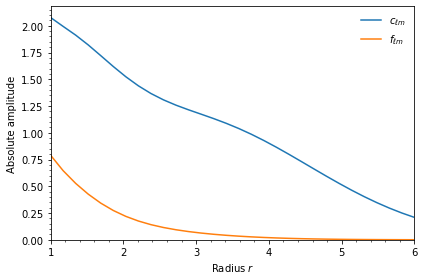

In [75]:
plt.figure(facecolor='white')

def radial(r, kappa):
    return r**(1/kappa - 1) * np.exp(-kappa*r)

def hyd_1s(r):
    return 1/np.sqrt(np.pi) * np.exp(-r)

sgn, l, m = 0,0,0
#plt.plot(r_lst, np.array([output.eval_orbital_spherical(r, np.pi/2, 0) for r in r_lst])*100, label=r'$\psi_0$')
plt.plot(r_lst, np.abs(np.array(flms)[:, sgn, l, m])/radial(r_lst, kappa), label=r'$c_{\ell m}$')
plt.plot(r_lst, np.abs(np.array(flms)[:, sgn, l, m]),  label=r'$f_{\ell m}$')
plt.legend(frameon=False)
plt.xlabel(r'Radius $r$')
plt.ylabel(r'Absolute amplitude')
plt.minorticks_on()
plt.xlim(r_lst[0], r_lst[-1])
plt.ylim(bottom=0)
plt.tight_layout()

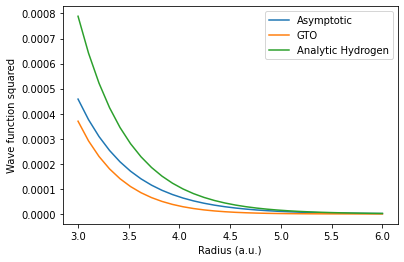

In [73]:
clm_array = se.get_as_coeffs(output.eval_orbital_spherical, 2.5, 30, Ip)

phi = 0
theta = 0

plt.figure(facecolor='white')
plt.plot(r_lst, np.abs(se.eval_asymptotic(r_lst, theta, phi, clm_array, Ip))**2, label='Asymptotic')
plt.plot(r_lst, np.abs(output.eval_orbital_spherical(r_lst, theta, phi))**2, label='GTO')
plt.plot(r_lst, np.abs(hyd_1s(r_lst))**2, label='Analytic Hydrogen')
plt.legend()
plt.xlabel('Radius (a.u.)')
plt.ylabel('Wave function squared')
plt.show()

### Now let's try to calculate the transition amplitude!